## 1. Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets

## 2. Load Data 

In [2]:
# Load MNIST (using torchvision) 
train_ds = datasets.MNIST(root="./data", train=True, download=True)
test_ds  = datasets.MNIST(root="./data", train=False, download=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 4.96MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.0MB/s]


In [ ]:
# datasets.MNIST stores data as torch tensors: data (uint8) shape (N,28,28), targets shape (N,)
x_train = train_ds.data.numpy()
y_train = train_ds.targets.numpy()
x_test  = test_ds.data.numpy()
y_test  = test_ds.targets.numpy()

print("Training set:", x_train.shape, y_train.shape)
print("Test set:", x_test.shape, y_test.shape)

Training set: (60000, 28, 28) (60000,)
Test set: (10000, 28, 28) (10000,)


## 3. Data Preprocessing

In [4]:
# Normalize pixel values (0–255 -> 0–1)
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

In [5]:
# Split training and validation data
X_train, X_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.1, random_state=42
)

print("Training set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set:", x_test.shape)

Training set: (54000, 28, 28)
Validation set: (6000, 28, 28)
Test set: (10000, 28, 28)


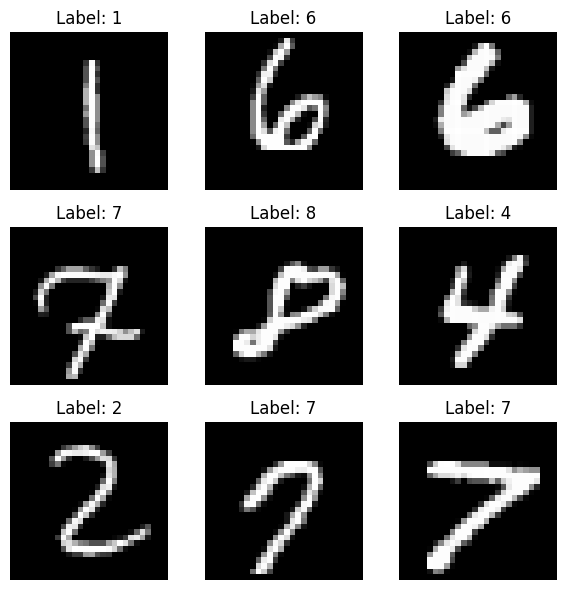

In [6]:
# Plot the first 9 images from the training set (use post-split arrays for consistency)
plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## 4. Model Definition and Compilation

In [7]:
# Convert numpy arrays to torch tensors
tensor_X_train = torch.tensor(X_train)    # shape (N,28,28)
tensor_y_train = torch.tensor(y_train, dtype=torch.long)
tensor_X_val   = torch.tensor(X_val)
tensor_y_val   = torch.tensor(y_val, dtype=torch.long)
tensor_X_test  = torch.tensor(x_test)
tensor_y_test  = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(tensor_X_train, tensor_y_train)
val_dataset   = TensorDataset(tensor_X_val, tensor_y_val)
test_dataset  = TensorDataset(tensor_X_test, tensor_y_test)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),   # 28 -> 26
            nn.ReLU(),
            nn.MaxPool2d(2),                   # 26 -> 13
            nn.Conv2d(32, 64, kernel_size=3),  # 13 -> 11
            nn.ReLU(),
            nn.MaxPool2d(2),                   # 11 -> 5
            nn.Flatten()
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 5 * 5, 128),
            nn.ReLU(),
            nn.Linear(128, 10)  # logits
        )

    def forward(self, x):
        # Accept (B,28,28) or (B,1,28,28)
        if x.dim() == 3:
            x = x.unsqueeze(1)  # (B,1,28,28)
        x = self.features(x)
        x = self.classifier(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

## 5. Model Training

In [8]:
# Training loop
epochs = 10
history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

for epoch in range(1, epochs+1):
    # Training
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        outputs = model(xb)                # shape (batch, 10)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        preds = outputs.argmax(dim=1)
        running_correct += (preds == yb).sum().item()
        total += xb.size(0)

    epoch_loss = running_loss / total
    epoch_acc  = running_correct / total

    # Validation
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    val_total = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)

            val_running_loss += loss.item() * xb.size(0)
            preds = outputs.argmax(dim=1)
            val_running_correct += (preds == yb).sum().item()
            val_total += xb.size(0)

    val_loss = val_running_loss / val_total
    val_acc  = val_running_correct / val_total

    history['loss'].append(epoch_loss)
    history['accuracy'].append(epoch_acc)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)

    print(f"Epoch {epoch}/{epochs} - loss: {epoch_loss:.4f} - acc: {epoch_acc:.4f} - val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}")

Epoch 1/10 - loss: 0.2816 - acc: 0.9141 - val_loss: 0.0838 - val_acc: 0.9762
Epoch 2/10 - loss: 0.0694 - acc: 0.9786 - val_loss: 0.0537 - val_acc: 0.9838
Epoch 3/10 - loss: 0.0495 - acc: 0.9847 - val_loss: 0.0632 - val_acc: 0.9797
Epoch 4/10 - loss: 0.0382 - acc: 0.9882 - val_loss: 0.0371 - val_acc: 0.9897
Epoch 5/10 - loss: 0.0310 - acc: 0.9904 - val_loss: 0.0375 - val_acc: 0.9885
Epoch 6/10 - loss: 0.0257 - acc: 0.9920 - val_loss: 0.0387 - val_acc: 0.9872
Epoch 7/10 - loss: 0.0200 - acc: 0.9935 - val_loss: 0.0373 - val_acc: 0.9900
Epoch 8/10 - loss: 0.0176 - acc: 0.9944 - val_loss: 0.0353 - val_acc: 0.9902
Epoch 9/10 - loss: 0.0137 - acc: 0.9955 - val_loss: 0.0348 - val_acc: 0.9908
Epoch 10/10 - loss: 0.0116 - acc: 0.9961 - val_loss: 0.0454 - val_acc: 0.9880


## 6. Ploting accuracy and loss 

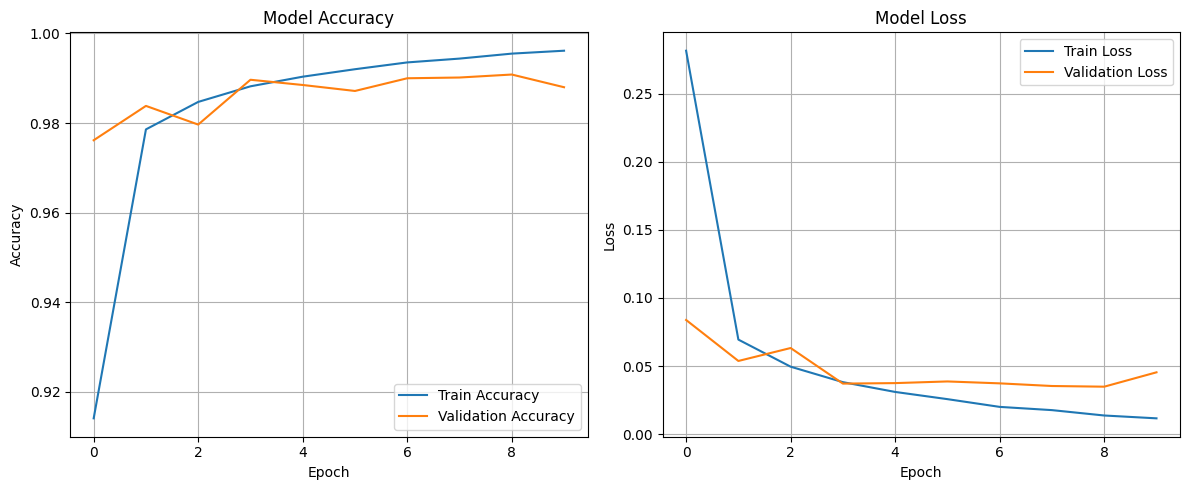

In [9]:
# Plot training history
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Loss
plt.subplot(1,2,2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

## 7. Evaluation

In [10]:
# Evaluate on the test set
model.eval()
test_running_loss = 0.0
test_running_correct = 0
test_total = 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        outputs = model(xb)
        loss = criterion(outputs, yb)

        test_running_loss += loss.item() * xb.size(0)
        preds = outputs.argmax(dim=1)
        test_running_correct += (preds == yb).sum().item()
        test_total += xb.size(0)

test_loss = test_running_loss / test_total
test_accuracy = test_running_correct / test_total

print("\nMODEL EVALUATION:")
print(f'test set accuracy: {test_accuracy}')
print(f'test set loss: {test_loss}')


MODEL EVALUATION:
test set accuracy: 0.9888
test set loss: 0.03504027822325006
